In [1]:
pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf

In [3]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

In [4]:
tickers = ['AGG', 'VUG', 'GLD', 'VTV', 'QQQ']

In [5]:
end_date = datetime.today()

In [6]:
start_date = end_date - timedelta(days = 15*365)
print(start_date)

2010-05-22 15:37:33.267446


In [7]:
adj_close_df = pd.DataFrame()

In [8]:
for ticker in tickers:
    data = yf.download(ticker, start = start_date, end = end_date, auto_adjust=0)
    adj_close_df[ticker] = data['Adj Close']
    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
adj_close_df.shape

(3770, 5)

In [10]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))

In [11]:
log_returns.dropna(inplace=True)

In [12]:
log_returns.isna().sum()

AGG    0
VUG    0
GLD    0
VTV    0
QQQ    0
dtype: int64

In [13]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)

          AGG       VUG       GLD       VTV       QQQ
AGG  0.002308  0.000411  0.002280 -0.000243  0.000316
VUG  0.000411  0.039728  0.001787  0.027446  0.040734
GLD  0.002280  0.001787  0.024377  0.000941  0.001633
VTV -0.000243  0.027446  0.000941  0.027855  0.027327
QQQ  0.000316  0.040734  0.001633  0.027327  0.043651


In [14]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)


In [15]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

In [16]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return(expected_return(weights, log_returns) - risk_free_rate)/standard_deviation(weights, cov_matrix)

In [17]:
risk_free_rate = 0.02

In [18]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

In [25]:
constraints  = {'type':'eq', 'fun': lambda weights: np.sum(weights)-1}
bounds = [(0,0.4) for _ in range(len(tickers))]

In [26]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


In [27]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args = (log_returns, cov_matrix, risk_free_rate), method= "SLSQP", constraints=constraints, bounds=bounds)

In [28]:
optimal_weights = optimized_results.x

In [29]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
AGG: 0.2145
VUG: 0.0000
GLD: 0.2443
VTV: 0.1412
QQQ: 0.4000
Expected Annual Return: 0.1051
Expected Volatility: 0.1134
Sharpe Ratio: 0.7508


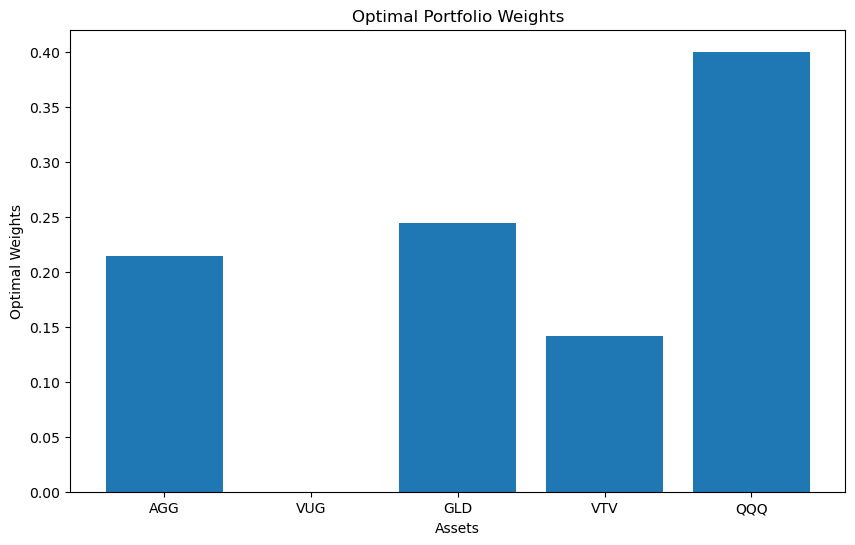

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()